# RNN의 변형 LSTM 의 또다른 변형 핍홀 LSTM

- 핍홀 LSTM의 실험적 구성을 작성해본다.
- 이를 자신의 RNN계층에서 사용하려면 다음의 코드처럼 RNN래퍼에서 셀을 래핑해야함

In [3]:
import tensorflow as tf
from tensorflow.keras import experimental, layers

hidden_dim = 256
peephole_cell = tf.keras.experimental.PeepholeLSTMCell(hidden_dim)
rnn_layer = tf.keras.layers.RNN(peephole_cell)

## 양방향 RNN

- 양방향 LSTM은 본질적으로 두 개의 RNN을 서로의 위에 쌓은 것인데, 하나는 왼쪽에서 오른쪽으로 입력을 읽고 다른 하나는 오른쪽에서 왼쪽으로 입력을 읽는다.
- 양방향 RNN을 사용하면 신경망이 시퀀스의 시작과 끝을 동일하게 강조할 수 있으므로 일반적으로 성능이 향상됨.
- RNN계층을 양방향으로 만들려면 다음과 같은 래퍼 계층으로 계층을 래핑하면 된다.

In [6]:
import tensorflow as tf
from tensorflow.keras import layers

self.lstm = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(10, return_sequences=True,
    input_shape=(5, 10)))

NameError: name 'self' is not defined

## 일대다 텍스트 생성 학습 예제

- 단일 입력에 대해 시퀀스를 출력
- 이러한 신경망의 예는 이미지애서 택스트 태그를 생성하는것으로, 이미지의 여러 측면에 관한 간단한 텍스트 설명을 포함한다.(ex. cat -> 1)
- 이러한 신경망은 이미지 입력과 이미지 태그를 나타내는 레이블된 텍스트 시퀀스로 훈련된다.

In [7]:
import os
import numpy as np
import re
import shutil
import tensorflow as tf

DATA_DIR = './data'
CHECKPOINT_DIR = "./checkpoint/RNN"

In [8]:
def download_and_read(urls):
    texts = []
    for i, url in enumerate(urls):
        p = tf.keras.utils.get_file('ex1-{:d}.txt'.format(i), url, cache_dir='.')
        text = open(p, 'r').read()
        # 바이트 순서 표시 문자 제거
        text = text.replace('\ufeff', '')
        # 줄 바꿈 표시 문자 제거
        text = text.replace('\n', '')
        text = re.sub(r'\s+', ' ', text)
        # 리스트에 추가
        texts.extend(text)
    return texts

texts = download_and_read([
    "http://www.gutenberg.org/cache/epub/28885/pg28885.txt",
    "https://www.gutenberg.org/files/12/12-0.txt"])

196608/193607 [==============================] - 1s 3us/step


- 다음은 어휘를 만든다. 이 경우 어휘에는 대문자와 소문자 알파벳, 숫자 및 특수문자로 구성된 90개의 고유한 문자가 포함된다. 또한 각 어휘 문자를 고유한 정수 또는 그 반대로 변환하고자 일부 매핑 사전을 작성함
- 이 신경망의 입출력은 문자 시퀀스이다. 그러나 신경망의 실제 입출력은 정수 시퀀스이기 때문에 매핑 사전을 사용해 이런 변환을 처리한다.

In [9]:
# 어휘 생성
vocab = sorted(set(texts))
print('vocab size: {:d}'.format(len(vocab)))

# 어휘 문자에서 정수로 매핑 생성
char2idx = {c:i for i, c in enumerate(vocab)}
idx2char = {i:c for c, i in char2idx.items()}

# 텍스트를 수치화
texts_as_ints = np.array([char2idx[c] for c in texts])
data = tf.data.Dataset.from_tensor_slices(texts_as_ints)

# 예측하기 전에 보여줄 문자 개수
# sequences: [None, 100]
seq_length = 100
sequences = data.batch(seq_length + 1, drop_remainder=True)

def split_train_labels(sequence):
    input_seq = sequence[0:-1]
    output_seq = sequence[1:]
    return input_seq, output_seq

sequences = sequences.map(split_train_labels)
# 훈련을 위한 설정
# 배치: [None, 64, 100]
batch_size = 64
steps_per_epoch = len(texts) // seq_length // batch_size
dataset = sequences.shuffle(10000).batch(batch_size, drop_remainder=True)

vocab size: 90


- 이제 신경망을 정의한다.
- 크기가 100인 정수(num_timestep)의 시퀀스를 입력으로 취해 임베딩 계층을 통해 전달해서 시퀀스의 각 정수가 256크기의 벡터(embedding_dim)로 변환되게 한다. 따라서 배치 크기가 64라고 가정하면 입력 시퀀스 크기(64,100)의 임베딩 계층 출력은 (64,100,256)형태의 행렬이다.
- 다음 계층은 100개의 타임 스텝을 가진 RNN 계층이다. 구현방식은 GRU, 각각의 타임 스텝에서 크기(256,)인 벡터를 취하고 (1024,)형태의 벡터(rnn_output_dim)를 출력한다. 이 RNN모델은 상태저장이다. 또한 return_sequence = True 플래그는 RNN이 마지막 타임 스텝의 집계 출력이 아니라 각 타임스텝에서 출력됨을 나타냄.
- 마지막으로 각 타임스텝은 (1024,)형태의 벡터를 밀집계층으로 방출해 형태가 (90,)인 벡터(vocab_size)를 출력한다. 이 계층의 출력은 모양이(64,100,90)인 텐서가 된다.
- 출력 벡터의 각 위치는 어휘의 문자에 해당하고 값은 해당 출력 위치에서 해당 문자가 발생할 확률에 해당한다.

Model: "char_gen_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  23040     
_________________________________________________________________
gru (GRU)                    multiple                  107400    
_________________________________________________________________
dense (Dense)                multiple                  9090      
Total params: 139,530
Trainable params: 139,530
Non-trainable params: 0
_________________________________________________________________


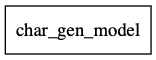

In [10]:
class CharGenModel(tf.keras.Model):
    def __init__(self, vocab_size, num_timesteps, embedding_dim, rnn_output_dim, **kwargs):
        super(CharGenModel, self).__init__(**kwargs)
        self.embedding_layer = tf.keras.layers.Embedding(
            vocab_size,
            embedding_dim)
        self.rnn_layer = tf.keras.layers.GRU(
            num_timesteps,
            recurrent_initializer='glorot_uniform',
            recurrent_activation='sigmoid',
            stateful=True,
            return_sequences=True)
        self.dense_layer = tf.keras.layers.Dense(vocab_size)
    def call(self, x):
        x = self.embedding_layer(x)
        x = self.rnn_layer(x)
        x = self.dense_layer(x)
        return x

vocab_size = len(vocab)
embedding_dim = 256
rnn_output_dim = 1024

model = CharGenModel(vocab_size, seq_length, embedding_dim, rnn_output_dim)
model.build(input_shape=(batch_size, seq_length))
model.summary()
tf.keras.utils.plot_model(model, 'model/RNN(1:n,GRU)/GRU_gen.png', True)

- 다음으로 손실함수를 정의하고 모델을 컴파일한다.
- 여기서는 희소 범주형 교차 엔트로피(sparse_categorical_crossentropy)를 손실 함수로 사용하는데, 입력과 출력이 정수 시퀀스일 때 사용되는 표준 손실 함수이기 때문이다.
- 최적화기는 Adam을 선택

In [11]:
def loss(labels, predictions):
    return tf.losses.sparse_categorical_crossentropy(
        labels,
        predictions,
        from_logits=True)

model.compile(optimizer=tf.optimizers.Adam(), loss=loss)

In [15]:
def generate_text(model, prefix_string, char2idx, idx2char, num_chars_to_generate=10000, temperature=1.0):
    input = [char2idx[s] for s in prefix_string]
    input = tf.expand_dims(input, 0)
    text_generated = []
    model.reset_states()
    for i in range(num_chars_to_generate):
        preds = model(input)
        preds = tf.squeeze(preds, 0) / temperature
        # 모델이 반환한 문자 예측
        pred_id = tf.random.categorical(
            preds, num_samples=1)[-1, 0].numpy()
        text_generated.append(idx2char[pred_id])
        # 예측을 모델의 다음 입력으로 전달
        input = tf.expand_dims([pred_id], 0)
    
    return prefix_string + "".join(text_generated)

In [20]:
num_epochs = 50
for i in range(num_epochs // 10):
    model.fit(
        dataset.repeat(),
        epochs=10,
        steps_per_epoch=steps_per_epoch
        # callbacks=[checkpoint_callback, tensorboard_callback]
    )

    checkpoint_file = os.path.join(
        CHECKPOINT_DIR, "model_epoch_{:d}".format(i+1))
    model.save_weights(checkpoint_file)

    # 지금까지(10에폭마다) 훈련된 모델을 사용해 생성 모델 재구축
    gen_model = CharGenModel(vocab_size, seq_length, embedding_dim, rnn_output_dim)
    gen_model.load_weights(checkpoint_file)
    gen_model.build(input_shape=(1, seq_length))

    print("after epoch: {:d}".format(i+1)*10)
    print(generate_text(gen_model, "Alice ", char2idx, idx2char))
    print("---")

ht like little gabled, ‘Now.""Noor, could it, and "It wouldons be a fattle down and quite it less, as you go and come under on, persaised Alice speak.Hown’queter’me, with the had thing-prible for fetcrosempatfinged off again. Fover to goodroly, I began."Th it melunted too attencess, I'm just to see away yoptring.‘All going orcourned down ne work way withthings time!""You much at here voice."N't," shouting her. If wis--and, that with which, with it whether shall thisK--this hireday or two this jock not voice--in the more time. And you minethatfully.‘To say--ho, "Which said to,” if of my agreeme in find a word man’t?’ the Queen: And.‘It’s u surewhat it's hand, and a little strinking like any buy not are go join was not white take the fay and round a-- wondrogwinto mose," home rounch had in her much permaythe (did get so, when she could her best grave Archive Fryks, if too liked the Project Gutenberghis westributieftles and up to ME all hall!’ she a nile, thoese!’ she said to anyittion by

## 다대일 감정 분석 예제

- 이 예제에서는 문장을 입력, 해당 감정을 양수나 음수로 예측해본다.
- 데이터셋은 UCI 머신러닝 저장소에 있는 레이블된 문장집합(Amazon,IMDb,Yelp 등에서 구한 3000여개의 문장 집합으로서 부정적인 감정을 표현할 경우 0으로 레이블되고 긍정적인 감정을 표현할 경우에는 1로 레이블된다.)

In [1]:
import os
import numpy as np
import shutil
import tensorflow as tf

from sklearn.metrics import accuracy_score, confusion_matrix

In [4]:
def download_and_read(url):
    local_file = url.split('/')[-1]
    local_file = local_file.replace('%20', ' ')
    p = tf.keras.utils.get_file(local_file, url, extract=True, cache_dir='.')
    local_folder = os.path.join("./datasets", local_file.split('.')[0])
    labeled_sentences = []
    for labeled_filename in os.listdir(local_folder):
        if labeled_filename.endswith('_labelled.txt'):
            with open(os.path.join(
                    local_folder, labeled_filename), 'r') as f:
                for line in f:
                    sentence, label = line.strip().split('\t')
                    labeled_sentences.append((sentence, label))
    return labeled_sentences

labeled_sentences = download_and_read(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/' +
    '00331/sentiment%20labelled%20sentences.zip')
sentences = [s for (s, l) in labeled_sentences]
labels = [int(l) for (s, l) in labeled_sentences]

In [17]:
np.shape(sentences), sentences[0], type(sentences)

((3000,),
 'So there is no way for me to plug it in here in the US unless I go by a converter.',
 list)

In [18]:
sentences[:5]

['So there is no way for me to plug it in here in the US unless I go by a converter.',
 'Good case, Excellent value.',
 'Great for the jawbone.',
 'Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!',
 'The mic is great.']

- 여기서의 목표는 입력된 문장에 대해 제공된 레이블에 있는 해당 감정을 예측하는 방법을 학습하도록 모델을 훈련시키는 것이다.
- 각 문장은 단어의 시퀀스이다. 그러나 모델에 입력하려면 정수 시퀀스로 변환해야 한다.
- 시퀀스의 각 정수는 단어를 가리킨다.
- 말뭉치의 단어를 정수로 매핑한 것을 어휘라고 한다.
- 따라서 문장을 토큰화하고 어휘를 만들어야 함

In [8]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sentences)
vocab_size = len(tokenizer.word_counts)
print('vocabulary size: {:d}'.format(vocab_size))

word2idx = tokenizer.word_index
idx2word = {v:k for (k, v) in word2idx.items()}

vocabulary size: 5271


In [25]:
seq_lengths = np.array([len(s.split()) for s in sentences])
print([(p, np.percentile(seq_lengths, p)) for p in [75,80,90,95,99,100]])

[(75, 16.0), (80, 18.0), (90, 22.0), (95, 26.0), (99, 36.0), (100, 71.0)]


- 결과에서 보듯 최대 문장 길이는 71단어지만 문장의 99%는 36단어 이하이다. 예를 들어 64라는 값을 선택한다면 대부분의 문장을 자를 필요 없다.
- 다음 단계는 모델이 사용할 수 있는 데이터셋을 만든다.
- 먼저 훈련된 토크나이저를 사용해 각 문장을 단어 시퀀스에서 정수 시퀀스로 변환한다. 여기서 각 해당 정수는 tokenizer.word_index에 있는 단어의 인덱스다. 그런 다음 잘리고 0으로 채워짐
- 레이블은 넘파이 배열 labels_as_ints로 변환되고, 마지막으로 텐서 sentences_as_ints와 labels_as_ints를 결합해 텐서플로 데이터셋을 형성한다.

In [11]:
max_seqlen = 64

# 데이터셋 생성
sentences_as_ints = tokenizer.texts_to_sequences(sentences)
sentences_as_ints = tf.keras.preprocessing.sequence.pad_sequences(
    sentences_as_ints, maxlen=max_seqlen)
labels_as_ints = np.array(labels)
dataset = tf.data.Dataset.from_tensor_slices((sentences_as_ints, labels_as_ints))

In [15]:
np.shape(sentences_as_ints), sentences_as_ints[0]

((3000, 64),
 array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   27,
          48,    5,   56,  116,   12,   70,    7,  370,    6,   11,   64,
          11,    1,  186,  578,    3,   75,   60,    4, 2267], dtype=int32))

- 데이터셋의 1/3은 평가용으로 남겨두려 한다. 나머지 데이터 2/3중 10%는 모델이 훈련 중 자체 진행상황을 측정하는데 사용할 인라인 검증 데이터셋으로 사용하고 90%는 훈련 데이터셋으로 사용한다.
- 마지막으로 각 데이터셋에 대해 64문장의 배치를 만든다.

In [27]:
dataset = dataset.shuffle(10000)
test_size = len(sentences) // 3
val_size = (len(sentences) - test_size) // 10
test_dataset = dataset.take(test_size)
val_dataset = dataset.skip(test_size).take(val_size)
train_dataset = dataset.skip(test_size + val_size)

batch_size = 64
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

- 각 입력 문장은 max_seqlen(64) 크기의 정수 시퀀스다.
- 이는 임베딩 계층에 입력돼 각 단어를 어휘+1 크기의 벡터로 변환함
- 그다음 양방향 LSTM 계층으로 공급되고, 이는 각 단어를 크기 64의 벡터로 변환함
- 각 타임스텝에서 LSTM의 출력은 밀집계층으로 공금되고 이는 ReLU 활성화와 함께 크기 64인 벡터를 생성함
- 이 밀집계층의 출력은 다른 밀집 계층으로 공급되고, 이는 각 타임스텝에서 (1,)형태의 벡터를 출력하고 sigmoid 활성화를 통해 변조됨
- 모델은 이진 교차 엔트로피(binary_crossentropy)손실 함수와 Adam최적화기를 사용해 컴파일되고 10에폭 동안 훈련한다.

In [28]:
class SentimentAnalysisModel(tf.keras.Model):
    def __init__(self, vocab_size, max_seqlen, **kwargs):
        super(SentimentAnalysisModel, self).__init__(**kwargs)
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, max_seqlen)
        self.bilstm = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(max_seqlen))
        self.dense = tf.keras.layers.Dense(64, activation='relu')
        self.out = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.embedding(x)
        x = self.bilstm(x)
        x = self.dense(x)
        x = self.out(x)
        return x
    
model = SentimentAnalysisModel(vocab_size+1, max_seqlen)
model.build(input_shape=(batch_size, max_seqlen))
model.summary()

Model: "sentiment_analysis_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      multiple                  337408    
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  66048     
_________________________________________________________________
dense_6 (Dense)              multiple                  8256      
_________________________________________________________________
dense_7 (Dense)              multiple                  65        
Total params: 411,777
Trainable params: 411,777
Non-trainable params: 0
_________________________________________________________________


In [29]:
# 컴파일
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
# 훈련
data_dir = './model/RNN_n_1_LSTM'
logs_dir = './logs/RNN_n_1_LSTM'
best_model_file = os.path.join(data_dir, 'best_model.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_model_file,
    save_weights_only=True,
    save_best_only=True)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)
num_epochs = 10
history = model.fit(train_dataset, epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[checkpoint, tensorboard])

Epoch 1/10
29/29 [==============================] - 2s 85ms/step - loss: 0.6930 - accuracy: 0.5239 - val_loss: 0.6865 - val_accuracy: 0.7250
Epoch 2/10
29/29 [==============================] - 1s 46ms/step - loss: 0.6435 - accuracy: 0.6633 - val_loss: 0.5277 - val_accuracy: 0.8200
Epoch 3/10
29/29 [==============================] - 1s 47ms/step - loss: 0.4094 - accuracy: 0.8394 - val_loss: 0.3169 - val_accuracy: 0.9050
Epoch 4/10
29/29 [==============================] - 1s 45ms/step - loss: 0.2522 - accuracy: 0.9133 - val_loss: 0.2109 - val_accuracy: 0.9150
Epoch 5/10
29/29 [==============================] - 1s 44ms/step - loss: 0.1736 - accuracy: 0.9389 - val_loss: 0.0873 - val_accuracy: 0.9650
Epoch 6/10
29/29 [==============================] - 1s 42ms/step - loss: 0.1281 - accuracy: 0.9578 - val_loss: 0.1077 - val_accuracy: 0.9650
Epoch 7/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0859 - accuracy: 0.9728 - val_loss: 0.0807 - val_accuracy: 0.9750
Epoch 8/10
29

In [32]:
%load_ext tensorboard
%tensorboard --logdir logs/RNN_n_1_LSTM

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 50841), started 0:01:21 ago. (Use '!kill 50841' to kill it.)

In [33]:
best_model = SentimentAnalysisModel(vocab_size+1, max_seqlen)
best_model.build(input_shape=(batch_size, max_seqlen))
best_model.load_weights(best_model_file)
best_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 데이터셋에 대해 모델을 평가하는 가장 쉬운 고급 방법은 model.evaluate() 호출을 사용하는 것이다.
test_loss, test_acc = best_model.evaluate(test_dataset)
print('test_loss: {:.3f}, test accuracy: {:.3f}'.format(test_loss, test_acc))

16/16 [==============================] - 0s 14ms/step - loss: 0.0368 - accuracy: 0.9910
test_loss: 0.037, test accuracy: 0.991


- 또한 model.predict()를 사용해 예측하고, 이를 개별적으로 레이블과 비교하고 외부 도구(예를들어 scikit-learn)를 사용해 결과를 계산한다.

In [51]:
inputs_b

<tf.Tensor: shape=(40, 64), dtype=int32, numpy=
array([[   0,    0,    0, ...,  215,   17, 1672],
       [   0,    0,    0, ..., 4035,    1, 1431],
       [   0,    0,    0, ...,    9,    1,   29],
       ...,
       [   0,    0,    0, ...,  292,  118,  246],
       [   0,    0,    0, ...,    4,   18, 2705],
       [   0,    0,    0, ...,   33,  243,  654]], dtype=int32)>

In [50]:
labels_b

<tf.Tensor: shape=(40,), dtype=int64, numpy=
array([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0])>

In [45]:
labels, predictions = [], []
idx2word[0] = "PAD"
is_first_batch = True
for test_batch in test_dataset:
    inputs_b, labels_b = test_batch
    pred_batch = best_model.predict(inputs_b)
    predictions.extend([(1 if p > 0.5 else 0) for p in pred_batch])
    labels.extend([l for l in labels_b])
    if is_first_batch:
        # 레이블, 예측, 문장 배치를 프린트
        print("------------------------\n" + 
        "LABEL\tPRED\tSENTENCE" + 
        "\n------------------------")
        for rid in range(inputs_b.shape[0]):
            words = [idx2word[idx] for idx in inputs_b[rid].numpy()]
            words = [w for w in words if w != "PAD"]
            sentence = " ".join(words)
            print("{:d}\t{:d}\t{:s}".format(labels[rid], predictions[rid], sentence))
        is_first_batch = False

print("\naccuracy score: {:.3f}".format(accuracy_score(labels, predictions)))
print("\nconfusion matrix")
print(confusion_matrix(labels, predictions))

------------------------
LABEL	PRED	SENTENCE
------------------------
0	0	all three broke within two months of use
0	0	lewis black's considerable talent is wasted here too as he is at his most incendiary when he is unrestrained which the pg 13 rating certainly won't allow
1	1	i'd advise anyone to go and see it
0	0	the holster that arrived did not match the photo in the ad
1	1	good price
0	0	spend your money and time some place else
1	1	overall i rate this movie a 10 out of a 1 10 scale
1	1	so far it has worked like a charm
0	0	i'm so sorry but i really can't recommend it to anyone
1	1	is pretty funny
1	1	great food for the price which is very high quality and house made
0	0	i does not maintain a connection with the computer while it is on my lap
0	0	this film and i use that word loosely is an insult to the movie going public
0	0	the ambiance isn't much better
1	0	i don't think you will be disappointed
0	0	no additional ear gels provided and no instructions whatsoever
1	1	i will continu

## 다대다 POS(품사) 태깅 예제

In [53]:
import nltk
nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     /Users/HumanRevolution/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

In [54]:
import numpy as np
import os
import shutil
import tensorflow as tf

In [80]:
def download_and_read(dataset_dir, num_pairs=None):
    sent_filename = os.path.join(dataset_dir, "treebank-sents.txt")
    poss_filename = os.path.join(dataset_dir, "treebank-poss.txt")
    if not(os.path.exists(sent_filename) and os.path.exists(poss_filename)):
        import nltk

        if not os.path.exists(dataset_dir):
            os.makedirs(dataset_dir)
        fsents = open(sent_filename, 'w')
        fposs = open(poss_filename, 'w')
        sentences = nltk.corpus.treebank.tagged_sents()
        for sent in sentences:
            fsents.write(" ".join([w for w, p in sent]) + '\n')
            fposs.write(" ".join([p for w, p in sent]) + '\n')

        fsents.close()
        fposs.close()
    sents, poss = [],[]
    with open(sent_filename, 'r') as fsent:
        for idx, line in enumerate(fsent):
            sents.append(line.strip())
            if num_pairs is not None and idx >= num_pairs:
                break

    with open(poss_filename, 'r') as fposs:
        for idx, line in enumerate(fposs):
            poss.append(line.strip())
            if num_pairs is not None and idx >= num_pairs:
                break
    return sents, poss

sents, poss = download_and_read("./datasets/RNN_n_n_GRU")
assert(len(sents) == len(poss))
print('# of records: {:d}'.format(len(sents)))

# of records: 3914


In [81]:
def tokenize_and_build_vocab(texts, vocab_size=None, lower=True):
    if vocab_size is None:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=lower)
    else:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(
            num_words=vocab_size+1, oov_token='UNK', lower=lower)
    tokenizer.fit_on_texts(texts)
    if vocab_size is not None:
        # 추가적 우회 방법 이슈 8092를 참고
        # https://github.com/keras-team/keras/issues/8092
        tokenizer.word_index = {e:i for e, i in tokenizer.word_index.items() if i <= vocab_size+1}
    word2idx = tokenizer.word_index
    idx2word = {v:k for k, v in word2idx.items()}
    return word2idx, idx2word, tokenizer

word2idx_s, idx2word_s, tokenizer_s = tokenize_and_build_vocab(
    sents, vocab_size=9000)
word2idx_t, idx2word_t, tokenizer_t = tokenize_and_build_vocab(
    poss, vocab_size=38, lower=False)
source_vocab_size = len(word2idx_s)
target_vocab_size = len(word2idx_t)
print('vocab sizes (source): {:d}, (target): {:d}'.format(
    source_vocab_size, target_vocab_size))

vocab sizes (source): 9001, (target): 39


- 문장의 토큰수와 해당 POS태그 순서는 동일하지만 문장의 길이는 달라진다.
- 신경망은 동일한 입력길이를 넣어줘야 하므로 문장길이를 지정해줘야 한다.
- 다음의 코드는 다양한 백분위수를 계산하고 그에 해당하는 문장길이를 출력해준다.

In [82]:
sequence_lengths = np.array([len(s.split()) for s in sents])
print([(p, np.percentile(sequence_lengths, p)) for p in [75,80,90,95,99,100]])

[(75, 33.0), (80, 35.0), (90, 41.0), (95, 47.0), (99, 58.0), (100, 271.0)]


- 문장 길이를 100정도로 설정한다면 대부분 문제없이 지나가고 그중 몇 개는 잘려나갈 것이다. 선택한 길이보다 짧은 문장은 끝이 채워진다. 그러나 여기서는 데이터셋이 작기 때문에 최대한 많이 사용하는 것이 더 선호되므로 최대 길이로 선택한다.
- 다음 단계는 입력에서 데이터셋을 만드는 것이다.
- 첫째, 입출력 시퀀스의 토큰시퀀스와 POS태그를 정수 시퀀스로 변환
- 둘째, 최대 문장길이보다 더 짧은 시퀀스는 최대길이인 271로 채운다.
- #### POS 태그 시퀀스를 정수 시퀀스로 변환후 그대로 유지하지 않고 패딩 후 추가적인 연산을 수행하는데 to_categorical() 함수를 사용해 원핫 인코딩 시퀀스로 변환한다는 것에 주목
- 셋째, from_tensor_slices() 함수를 사용해 데이터셋을 생성하고 '섞은 후' 훈련,검증,테스트 집합으로 분할한다.

In [83]:
max_seqlen = 271
sents_as_ints = tokenizer_s.texts_to_sequences(sents)
sents_as_ints = tf.keras.preprocessing.sequence.pad_sequences(
    sents_as_ints, maxlen=max_seqlen, padding='post')
poss_as_ints = tokenizer_t.texts_to_sequences(poss)
poss_as_ints = tf.keras.preprocessing.sequence.pad_sequences(
    poss_as_ints, maxlen=max_seqlen, padding='post')
poss_as_catints = []
for p in poss_as_ints:
    poss_as_catints.append(tf.keras.utils.to_categorical(
        p, num_classes=target_vocab_size, dtype='int32'))
poss_as_catints = tf.keras.preprocessing.sequence.pad_sequences(
    poss_as_catints, maxlen=max_seqlen)

dataset = tf.data.Dataset.from_tensor_slices((sents_as_ints, poss_as_catints))

idx2word_s[0], idx2word_t[0] = 'PAD', 'PAD'

# 훈련, 검증, 테스트 데이터셋으로 분할
dataset = dataset.shuffle(10000)
test_size = len(sents) // 3
val_size = (len(sents) - test_size) // 10
test_dataset = dataset.take(test_size)
val_dataset = dataset.skip(test_size).take(val_size)
train_dataset = dataset.skip(test_size + val_size)

# 배치 생성
batch_size = 128
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [84]:
train_dataset,val_dataset,test_dataset

(<BatchDataset shapes: ((None, 271), (None, 271, 39)), types: (tf.int32, tf.int32)>,
 <BatchDataset shapes: ((None, 271), (None, 271, 39)), types: (tf.int32, tf.int32)>,
 <BatchDataset shapes: ((None, 271), (None, 271, 39)), types: (tf.int32, tf.int32)>)

- 다음은 모델을 정의하고 인스턴스화 한다.
- 이 모델은 임베딩계층, 드롭아웃계층, 양방향 GRU계층, 밀집계층, 소프트맥스 활성화 계층으로 구성된 순차 모델이다.
- 입력은 형태가 (batch_size, max_seqlen)인 정수 시퀀스 배치, 임베딩 계층을 통과 후 출력은 형태가 (batch_size, max_seqlen, embedding_dim), 출력 차원이 256인 양방향 GRU의 해당 타임스텝으로 전달, GRU는 양방향이므로 하나의 GRU를 다른 GRU위에 쌓는 것과 같다. 따라서 나오는 텐서는 차원이 (batch_size, max_seqlen, 2 x rnn_output_dimension), 형태가 (batch_size, 1, 2 x rnn_output_dimension)인 각 타임스텝의 텐서는 밀집계층으로 공급, 각 타입스텝을 대상어휘와 같은 크기의 벡터, 즉 (batch_size, number_of_timesteps, output_vocab_size)로 변환, 최종 소프트맥스 계층은 각 타임스텝에 적용돼 출력 POS 토큰의 시퀀스를 반환, 마지막으로 일부 매개변수를 선언, Adam최적화기, 범주형 교차 엔트로피 손실함수, 척도-정확도로 설정하고 컴파일한다.

In [88]:
class POSTaggingModel(tf.keras.Model):
    def __init__(self, source_vocab_size, taeget_vocab_size, embedding_dim, max_seqlen, rnn_output_dim, **kwargs):
        super(POSTaggingModel, self).__init__(**kwargs)
        self.embed = tf.keras.layers.Embedding(
            source_vocab_size, embedding_dim, input_length=max_seqlen)
        self.dropout = tf.keras.layers.SpatialDropout1D(0.2)
        self.rnn = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(rnn_output_dim, return_sequences=True))
        self.dense = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(target_vocab_size))
        self.activation = tf.keras.layers.Activation('softmax')

    def call(self, x):
        x = self.embed(x)
        x = self.dropout(x)
        x = self.rnn(x)
        x = self.dense(x)
        x = self.activation(x)
        return x

def masked_accuracy():
    def masked_accuracy_fn(ytrue, ypred):
        ytrue = tf.keras.backend.argmax(ytrue, axis=-1)
        ypred = tf.keras.backend.argmax(ypred, axis=-1)
        mask = tf.keras.backend.cast(
            tf.keras.backend.not_equal(ypred, 0), tf.int32)
        matches = tf.keras.backend.cast(
            tf.keras.backend.equal(ytrue, ypred), tf.int32) * mask
        numer = tf.keras.backend.sum(matches)
        denom = tf.keras.backend.maximum(tf.keras.backend.sum(mask), 1)
        accuracy = numer / denom
        return accuracy
    return masked_accuracy_fn

embedding_dim = 128
rnn_output_dim = 256

model = POSTaggingModel(source_vocab_size, target_vocab_size, embedding_dim, max_seqlen, rnn_output_dim)
model.build(input_shape=(batch_size, max_seqlen))
model.summary()
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', masked_accuracy()])

Model: "pos_tagging_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     multiple                  1152128   
_________________________________________________________________
spatial_dropout1d_2 (Spatial multiple                  0         
_________________________________________________________________
bidirectional_5 (Bidirection multiple                  592896    
_________________________________________________________________
time_distributed_2 (TimeDist multiple                  20007     
_________________________________________________________________
activation_2 (Activation)    multiple                  0         
Total params: 1,765,031
Trainable params: 1,765,031
Non-trainable params: 0
_________________________________________________________________


In [86]:
num_epochs = 50

data_dir = './model/RNN_n_n_GRU'
logs_dir = './logs/RNN_n_n_GRU'

best_model_file = os.path.join(data_dir, 'best_model.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    best_model_file,
    save_weights_only=True,
    save_best_only=True)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[checkpoint, tensorboard])

Epoch 1/50
19/19 [==============================] - 29s 2s/step - loss: 1.4451 - accuracy: 0.8647 - masked_accuracy_fn: 0.0022 - val_loss: 0.3254 - val_accuracy: 0.9126 - val_masked_accuracy_fn: 0.0667
Epoch 2/50
19/19 [==============================] - 33s 2s/step - loss: 0.3265 - accuracy: 0.9175 - masked_accuracy_fn: 0.0916 - val_loss: 0.3109 - val_accuracy: 0.9240 - val_masked_accuracy_fn: 0.1059
Epoch 3/50
19/19 [==============================] - 32s 2s/step - loss: 0.3168 - accuracy: 0.9196 - masked_accuracy_fn: 0.1442 - val_loss: 0.3124 - val_accuracy: 0.9138 - val_masked_accuracy_fn: 0.1374
Epoch 4/50
19/19 [==============================] - 29s 2s/step - loss: 0.3017 - accuracy: 0.9149 - masked_accuracy_fn: 0.0834 - val_loss: 0.2962 - val_accuracy: 0.9137 - val_masked_accuracy_fn: 0.0535
Epoch 5/50
19/19 [==============================] - 30s 2s/step - loss: 0.2742 - accuracy: 0.9208 - masked_accuracy_fn: 0.1109 - val_loss: 0.2683 - val_accuracy: 0.9233 - val_masked_accuracy_f

In [89]:
# evaluate with test set
best_model = POSTaggingModel(source_vocab_size, target_vocab_size,
    embedding_dim, max_seqlen, rnn_output_dim)
best_model.build(input_shape=(batch_size, max_seqlen))
best_model.load_weights(best_model_file)
best_model.compile(
    loss="categorical_crossentropy",
    optimizer="adam", 
    metrics=["accuracy", masked_accuracy()])

test_loss, test_acc, test_masked_acc = best_model.evaluate(test_dataset)
print("test loss: {:.3f}, test accuracy: {:.3f}, masked test accuracy: {:.3f}".format(
    test_loss, test_acc, test_masked_acc))

11/11 [==============================] - 4s 382ms/step - loss: 0.0637 - accuracy: 0.9811 - masked_accuracy_fn: 0.7906
test loss: 0.064, test accuracy: 0.981, masked test accuracy: 0.791


In [90]:
# predict on batches
labels, predictions = [], []
is_first_batch = True
accuracies = []

for test_batch in test_dataset:
    inputs_b, outputs_b = test_batch
    preds_b = best_model.predict(inputs_b)
    # convert from categorical to list of ints
    preds_b = np.argmax(preds_b, axis=-1)
    outputs_b = np.argmax(outputs_b.numpy(), axis=-1)
    for i, (pred_l, output_l) in enumerate(zip(preds_b, outputs_b)):
        assert(len(pred_l) == len(output_l))
        pad_len = np.nonzero(output_l)[0][0]
        acc = np.count_nonzero(
            np.equal(
                output_l[pad_len:], pred_l[pad_len:]
            )
        ) / len(output_l[pad_len:])
        accuracies.append(acc)
        if is_first_batch:
            words = [idx2word_s[x] for x in inputs_b.numpy()[i][pad_len:]]
            postags_l = [idx2word_t[x] for x in output_l[pad_len:] if x > 0]
            postags_p = [idx2word_t[x] for x in pred_l[pad_len:] if x > 0]
            print("labeled  : {:s}".format(" ".join(["{:s}/{:s}".format(w, p) 
                for (w, p) in zip(words, postags_l)])))
            print("predicted: {:s}".format(" ".join(["{:s}/{:s}".format(w, p) 
                for (w, p) in zip(words, postags_p)])))
            print(" ")
    is_first_batch = False

accuracy_score = np.mean(np.array(accuracies))
print("pos tagging accuracy: {:.3f}".format(accuracy_score))

try/NN a/DT form/NN asking/VBG them/PRP 2/NONE to/TO check/VB one/CD of/IN three/CD answers/NNS 1/LS rrb/RRB no/RB the/DT wine/NN is/VBZ too/RB high/JJ lrb/LRB 2/CD responses/NNS rrb/RRB 2/LS rrb/RRB yes/RB it/PRP 's/VBZ high/JJ but/CC i/PRP 'll/MD take/VB it/PRP lrb/LRB 2/CD responses/NNS rrb/RRB 3/LS rrb/RRB i/PRP 'll/MD take/VB all/DT 0/NONE i/PRP can/MD get/VB t/NONE 3/LRB lrb/CD 58/NNS responses/RRB
predicted: 1/NONE offering/VBG the/DT wine/NN at/IN roughly/IN 65/CD u/NONE a/DT bottle/NN wholesale/NN lrb/LRB 100/CD u/NONE retail/NN rrb/CC he/PRP sent/VBD merchants/NNS around/IN the/DT country/NN a/DT form/NN asking/VBG them/PRP 2/NONE to/TO check/VB one/CD of/IN three/CD answers/NNS 1/NONE rrb/VBP no/DT the/DT wine/NN is/VBZ too/RB high/JJ lrb/LRB 2/CD responses/NNS rrb/RRB 2/WP rrb/RB yes/RB it/PRP 's/POS high/JJ but/CC i/PRP 'll/MD take/VB it/PRP lrb/LRB 2/CD responses/NNS rrb/WP 3/WP rrb/RRB i/PRP 'll/MD take/VB all/VB 0/NONE i/PRP can/MD get/VB t/NONE 3/CD lrb/CD 58/CD respon

## 기계 변역용 어텐션 없는 seq2seq(인코더-디코너 아키텍쳐) 예제

In [1]:
import nltk, re, shutil, os, unicodedata
import numpy as np
import tensorflow as tf

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [2]:
# 상수 정의
NUM_SENT_PAIRS = 30000
EMBEDDING_DIM = 256
ENCODER_DIM, DECODER_DIM = 1024, 1024
BATCH_SIZE = 64
NUM_EPOCHS = 250

# 문자를 아스키화, 인접한 문장에서 특정 문장 부호를 분리,
# 알파벳이 아니거나 이러한 특정 문장 부호 이외의 모든 문자를 제거하고,
# 마지막으로 문장을 소문자로 변환해주는 함수
def preprocess_sentence(sent):
    sent = "".join([c for c in unicodedata.normalize("NFD", sent) if unicodedata.category(c) != "Mn"])
    sent = re.sub(r"([!.?])", r" \1", sent)
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)
    sent = re.sub(r"\s+", " ", sent)
    sent = sent.lower()
    return sent

# 각 문장을 하나의 단어 시퀀스로 변환, 프랑스어 문장은 두 개의 시퀀스로 변환해주는 함수
def download_and_read():
    en_sents, fr_sents_in, fr_sents_out = [], [], []
    local_file = os.path.join("datasets/RNN_n_n_seq2seq", "fra.txt")
    with open(local_file, "r") as fin:
        for i, line in enumerate(fin):
            #print(line)
            #print(line.strip().split('\t'))
            #en_sent = line.strip().split('\t')[0]
            #fr_sent = line.strip().split('\t')[1]
            en_sent, fr_sent = line.strip().split('\t')[0:2]
            en_sent = [w for w in preprocess_sentence(en_sent).split()]
            fr_sent = preprocess_sentence(fr_sent)
            fr_sent_in = [w for w in ("BOS " + fr_sent).split()]
            fr_sent_out = [w for w in (fr_sent + " EOS").split()]
            en_sents.append(en_sent)
            fr_sents_in.append(fr_sent_in)
            fr_sents_out.append(fr_sent_out)
            if i >= NUM_SENT_PAIRS - 1:
                break
    return en_sents, fr_sents_in, fr_sents_out

sents_en, sents_fr_in, sents_fr_out = download_and_read()

In [3]:
# 영어, 프랑스의 입력시퀀스를 토큰화
tokenizer_en = tf.keras.preprocessing.text.Tokenizer(
    filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en)
data_en = tokenizer_en.texts_to_sequences(sents_en)
data_en = tf.keras.preprocessing.sequence.pad_sequences(
    data_en, padding='post')

tokenizer_fr = tf.keras.preprocessing.text.Tokenizer(
    filters="", lower=False)
tokenizer_fr.fit_on_texts(sents_fr_in)
tokenizer_fr.fit_on_texts(sents_fr_out)
data_fr_in = tokenizer_fr.texts_to_sequences(sents_fr_in)
data_fr_in = tf.keras.preprocessing.sequence.pad_sequences(
    data_fr_in, padding='post')
data_fr_out = tokenizer_fr.texts_to_sequences(sents_fr_out)
data_fr_out = tf.keras.preprocessing.sequence.pad_sequences(
    data_fr_out, padding='post')

# 영어, 프랑스 어휘 사전만들기
vocab_size_en = len(tokenizer_en.word_index)
word2idx_en = tokenizer_en.word_index
idx2word_en = {v:k for k, v in word2idx_en.items()}

vocab_size_fr = len(tokenizer_fr.word_index)
word2idx_fr = tokenizer_fr.word_index
idx2word_fr = {v:k for k, v in word2idx_fr.items()}

print('vocab size (en): {:d}, vocab size (fr): {:d}'.format(
    vocab_size_en, vocab_size_fr))

maxlen_en = data_en.shape[1]
maxlen_fr = data_fr_out.shape[1]
print('seqlen (en): {:d}, seqlen (fr): {:d}'.format(
    maxlen_en, maxlen_fr))

vocab size (en): 4352, vocab size (fr): 7574
seqlen (en): 8, seqlen (fr): 16


In [4]:
batch_size = BATCH_SIZE

# 데이터를 텐서플로 데이터셋으로 변환
dataset = tf.data.Dataset.from_tensor_slices((data_en, data_fr_in, data_fr_out))
# 데이터를 섞는다.
dataset = dataset.shuffle(10000)
# 훈련과 테스트 집합으로 분할
test_size = NUM_SENT_PAIRS // 4
test_dataset = dataset.take(test_size).batch(batch_size, drop_remainder=True)
train_dataset = dataset.skip(test_size).batch(batch_size, drop_remainder=True)

In [5]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, num_timesteps, embedding_dim, encoder_dim, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.encoder_dim = encoder_dim
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embedding_dim, input_length=num_timesteps)
        self.rnn = tf.keras.layers.GRU(
            encoder_dim, return_sequences=False, return_state=True)
    
    def call(self, x, state):
        x = self.embedding(x)
        x, state = self.rnn(x, initial_state=state)
        return x, state
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.encoder_dim))

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, num_timesteps, embedding_dim, decoder_dim, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.decoder_dim = decoder_dim
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embedding_dim, input_length=num_timesteps)
        self.rnn = tf.keras.layers.GRU(
            decoder_dim, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)
    
    def call(self, x, state):
        x = self.embedding(x)
        x, state = self.rnn(x, state)
        x = self.dense(x)
        return x, state
    
embedding_dim = EMBEDDING_DIM
encoder_dim, decoder_dim = ENCODER_DIM, DECODER_DIM

encoder = Encoder(vocab_size_en+1, embedding_dim, maxlen_en, encoder_dim)
decoder = Decoder(vocab_size_fr+1, embedding_dim, maxlen_fr, decoder_dim)

In [6]:
for encoder_in, decoder_in, decoder_out in train_dataset:
    encoder_state = encoder.init_state(batch_size)
    encoder_out, encoder_state = encoder(encoder_in, encoder_state)
    decoder_state = encoder_state
    decoder_pred, decoder_state = decoder(decoder_in, decoder_state)
    break

print('encoder input          :', encoder_in.shape)
print('encoder output         :', encoder_out.shape, 'state:', encoder_state.shape)
print('decoder output (logits):', decoder_pred.shape, 'state:', decoder_state.shape)
print('decoder output (labels):', decoder_out.shape)

encoder input          : (64, 8)
encoder output         : (64, 1024) state: (64, 1024)
decoder output (logits): (64, 16, 7575) state: (64, 1024)
decoder output (labels): (64, 16)


In [7]:
# 손실 함수
# 문장을 pad_sequences() 함수로 채웠기 때문에 레이블과 예측 사이에서
# 패드 단어의 동등성을 고려하므로 결과를 편향시키고 싶지는 않다.
# 이 함수는 레이블을 사용해 예측을 마스킹, 레이블의 패딩된 위치도 예측에서 제거,
# 레이블과 예측 모두에서 0이 아닌 요소만 사용해 손실을 계산하는 함수이다.
def loss_fn(ytrue, ypred):
    scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    mask = tf.math.logical_not(tf.math.equal(ytrue, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = scce(ytrue, ypred, sample_weight=mask)
    return loss

In [8]:
@tf.function
def train_step(encoder_in, decoder_in, decoder_out, encoder_state):
    with tf.GradientTape() as tape:
        encoder_out, encoder_state = encoder(encoder_in, encoder_state)
        decoder_state = encoder_state
        decoder_pred, decoder_state = decoder(decoder_in, decoder_state)
        loss = loss_fn(decoder_out, decoder_pred)
    
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss

In [9]:
def predict(encoder, decoder, batch_size, sents_en, data_en, sents_fr_out, word2idx_fr, idx2word_fr):
    random_id = np.random.choice(len(sents_en))
    print("input      : ", " ".join(sents_en[random_id]))
    print("label      : ", " ".join(sents_fr_out[random_id]))
    encoder_in = tf.expand_dims(data_en[random_id], axis=0)
    encoder_out = tf.expand_dims(sents_fr_out[random_id], axis=0)

    encoder_state = encoder.init_state(1)
    encoder_out, encoder_state = encoder(encoder_in, encoder_state)
    decoder_state = encoder_state
    decoder_in = tf.expand_dims(
        tf.constant([word2idx_fr['BOS']]), axis=0)
    pred_sent_fr = []
    while True:
        decoder_pred, decoder_state = decoder(decoder_in, decoder_state)
        decoder_pred = tf.argmax(decoder_pred, axis=-1)
        pred_word = idx2word_fr[decoder_pred.numpy()[0][0]]
        pred_sent_fr.append(pred_word)
        if pred_word == 'EOS':
            break
        decoder_in = decoder_pred
    print('predicted  : ', " ".join(pred_sent_fr))

def evaluate_bleu_score(encoder, decoder, test_dataset, word2idx_fr, idx2word_fr):
    bleu_scores = []
    smooth_fn = SmoothingFunction()
    for encoder_in, decoder_in, decoder_out in test_dataset:
        encoder_state = encoder.init_state(batch_size)
        encoder_out, encoder_state = encoder(encoder_in, encoder_state)
        decoder_state = encoder_state
        decoder_pred, decoder_state = decoder(decoder_in, decoder_state)

        # argmax 계산
        decoder_out = decoder_out.numpy()
        decoder_pred = tf.argmax(decoder_pred, axis=-1).numpy()

        for i in range(decoder_out.shape[0]):
            ref_sent = [idx2word_fr[j] for j in decoder_out[i].tolist() if j > 0]
            hyp_sent = [idx2word_fr[j] for j in decoder_pred[i].tolist() if j > 0]
            # 뒷부분 EOS 제거
            ref_sent = ref_sent[0:-1]
            hyp_sent = hyp_sent[0:-1]
            bleu_score = sentence_bleu([ref_sent], hyp_sent, smoothing_function=smooth_fn.method1)
            bleu_scores.append(bleu_score)

    return np.mean(np.array(bleu_scores))

In [10]:
checkpoint_dir = './checkpoint/RNN_n_n_seq2seq'

optimizer = tf.keras.optimizers.Adam()
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
    encoder=encoder, decoder=decoder)

num_epochs = NUM_EPOCHS
eval_scores = []

for e in range(num_epochs):
    encoder_state = encoder.init_state(batch_size)

    for batch, data in enumerate(train_dataset):
        encoder_in, decoder_in, decoder_out = data
        #print(encoder_in.shape, decoder_in.shape, decoder_out.shape)
        loss = train_step(encoder_in, decoder_in, decoder_out, encoder_state)
    
    print('Epoch: {}, Loss: {:.4f}'.format(e + 1, loss.numpy()))

    if e % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    predict(encoder, decoder, batch_size, sents_en, data_en, sents_fr_out, word2idx_fr, idx2word_fr)

    eval_score = evaluate_bleu_score(encoder, decoder, test_dataset, word2idx_fr, idx2word_fr)
    print("Eval Score (BLEU): {:.3f}".format(eval_score))
    eval_scores.append(eval_score)

checkpoint.save(file_prefix=checkpoint_prefix)

is it for me ?
label      :  est ce que c est pour moi ? EOS
predicted  :  est ce que c est pour moi ? EOS
Eval Score (BLEU): 0.177
Epoch: 129, Loss: 0.0721
input      :  this is so boring .
label      :  c est tellement chiant . EOS
predicted  :  c est tellement chiant . EOS
Eval Score (BLEU): 0.177
Epoch: 130, Loss: 0.0813
input      :  you can trust us .
label      :  tu peux nous faire confiance . EOS
predicted  :  vous pouvez nous faire confiance . EOS
Eval Score (BLEU): 0.177
Epoch: 131, Loss: 0.0968
input      :  are you a policeman ?
label      :  es tu un policier ? EOS
predicted  :  es tu un policier ? EOS
Eval Score (BLEU): 0.177
Epoch: 132, Loss: 0.0815
input      :  what a day !
label      :  quelle journee ! EOS
predicted  :  quelle journee ! EOS
Eval Score (BLEU): 0.177
Epoch: 133, Loss: 0.0776
input      :  do you have a comb ?
label      :  as tu un peigne ? EOS
predicted  :  as tu un peigne ? EOS
Eval Score (BLEU): 0.177
Epoch: 134, Loss: 0.1016
input      :  you re a

'./checkpoint/RNN_n_n_seq2seq/ckpt-26'

## 어텐션 메커니즘(seq2seq 성능 향상)
- 어텐션 메커니즘은 디코더의 모든 타임 스텝에서 모든 인코너 은닉 상태에 대한 액세스를 제공한다.
- 디코더는 인코더 상태 중 어느 부분에 더 많은 주의(attention)를 기울여야 하는지 학습한다.
- 어텐션은 최적의 딥러닝 모델을 만들기 위한 NLP 공식인 '임베딩,인코딩,어텐션,예측'의 핵심 구성 요소다.
- 여기서는 단어 벡터 시퀀스를 단일 문장 벡터로 축소 할 때처럼 더 큰 표현에서 더 작은 표현으로 축소할 때 가능한 한 많은 정보를 보존하고자 어텐션을 사용한다.

## 기계 번역용 어텐션 있는 seq2seq 예제

In [1]:
import nltk, re, shutil, os, unicodedata, zipfile
import numpy as np
import tensorflow as tf

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [2]:
def preprocess_sentence(sent):
    sent = "".join([c for c in unicodedata.normalize("NFD", sent) 
        if unicodedata.category(c) != "Mn"])
    sent = re.sub(r"([!.?])", r" \1", sent)
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)
    sent = re.sub(r"\s+", " ", sent)
    sent = sent.lower()
    return sent

def download_and_read(num_sent_pairs=30000):
    local_file = os.path.join("datasets/RNN_n_n_seq2seq", "fra.txt")
    en_sents, fr_sents_in, fr_sents_out = [], [], []
    with open(local_file, "r") as fin:
        for i, line in enumerate(fin):
            en_sent, fr_sent = line.strip().split('\t')[0:2]
            en_sent = [w for w in preprocess_sentence(en_sent).split()]
            fr_sent = preprocess_sentence(fr_sent)
            fr_sent_in = [w for w in ("BOS " + fr_sent).split()]
            fr_sent_out = [w for w in (fr_sent + " EOS").split()]
            en_sents.append(en_sent)
            fr_sents_in.append(fr_sent_in)
            fr_sents_out.append(fr_sent_out)
            if i >= num_sent_pairs - 1:
                break
    return en_sents, fr_sents_in, fr_sents_out

# 바다나우 어텐션(가산적 어텐션) 추가
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, num_units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(num_units)
        self.W2 = tf.keras.layers.Dense(num_units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # 쿼리는 타임 스텝 j에서의 디코더 상태다.
        # query.shape: (batch_size, num_units)
        # 값은 모든 타임 스텝 1에서 인코더 상태다.
        # values.shape: (batch_size, num_timesteps, num_units)

        # 쿼리에 시각 축 추가: (batch_size, 1, num_units)
        query_with_time_axis = tf.expand_dims(query, axis=1)
        # 점수 계산
        score = self.V(tf.keras.activations.tanh(
            self.W1(values) + self.W2(query_with_time_axis)))
        # 소프트맥스 계산
        alignment = tf.nn.softmax(score, axis=1)
        # 어텐션된 출력 계산
        context = tf.reduce_sum(
            tf.linalg.matmul(
                tf.linalg.matrix_transpose(alignment),
                values
            ), axis=1
        )
        context = tf.expand_dims(context, axis=1)
        return context, alignment

# 루옹 어텐션(곱 어텐션) 추가
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, num_units):
        super(LuongAttention, self).__init__()
        self.W = tf.keras.layers.Dense(num_units)

    def call(self, query, values):
        # 질의에 시각 축을 추가한다.
        query_with_time_axis = tf.expand_dims(query, axis=1)
        # 점수 계산
        score = tf.linalg.matmul(
            query_with_time_axis, self.W(values), transpose_b=True)
        # 소프트맥스 계산
        alignment = tf.nn.softmax(score, axis=2)
        # 어텐션된 출력 계산
        context = tf.matmul(alignment, values)
        return context, alignment

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, num_timesteps, 
            embedding_dim, encoder_dim, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.encoder_dim = encoder_dim
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embedding_dim, input_length=num_timesteps)
        self.rnn = tf.keras.layers.GRU(
            encoder_dim, return_sequences=True, return_state=True)  # return_sequences=False -> True 로 변경

    def call(self, x, state):
        x = self.embedding(x)
        x, state = self.rnn(x, initial_state=state)
        return x, state

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.encoder_dim))

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, num_timesteps,
            decoder_dim, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.decoder_dim = decoder_dim

        #self.attention = BahdanauAttention(embedding_dim) # 추가
        self.attention = LuongAttention(embedding_dim)     # 추가

        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embedding_dim, input_length=num_timesteps)
        self.rnn = tf.keras.layers.GRU(
            decoder_dim, return_sequences=True, return_state=True)

        self.Wc = tf.keras.layers.Dense(decoder_dim, activation="tanh")  # 추가
        self.Ws = tf.keras.layers.Dense(vocab_size)                      # 추가

    def call(self, x, state, encoder_out):
        x = self.embedding(x)
        context, alignment = self.attention(x, encoder_out)
        x = tf.expand_dims(
                tf.concat([
                    x, tf.squeeze(context, axis=1)
                ], axis=1), 
            axis=1)
        x, state = self.rnn(x, state)
        x = self.Wc(x)
        x = self.Ws(x)
        return x, state, alignment

def loss_fn(ytrue, ypred):
    scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    mask = tf.math.logical_not(tf.math.equal(ytrue, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = scce(ytrue, ypred, sample_weight=mask)
    return loss

@tf.function
def train_step(encoder_in, decoder_in, decoder_out, encoder_state):
    with tf.GradientTape() as tape:
        encoder_out, encoder_state = encoder(encoder_in, encoder_state)
        decoder_state = encoder_state

        loss = 0
        for t in range(decoder_out.shape[1]):
            decoder_in_t = decoder_in[:, t]
            decoder_pred_t, decoder_state, _ = decoder(decoder_in_t,
                decoder_state, encoder_out)
            loss += loss_fn(decoder_out[:, t], decoder_pred_t)

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss / decoder_out.shape[1]

def predict(encoder, decoder, batch_size, sents_en, data_en, sents_fr_out, word2idx_fr, idx2word_fr):
    random_id = np.random.choice(len(sents_en))
    print("input    : ",  " ".join(sents_en[random_id]))
    print("label    : ", " ".join(sents_fr_out[random_id]))

    encoder_in = tf.expand_dims(data_en[random_id], axis=0)
    decoder_out = tf.expand_dims(sents_fr_out[random_id], axis=0)

    encoder_state = encoder.init_state(1)
    encoder_out, encoder_state = encoder(encoder_in, encoder_state)
    decoder_state = encoder_state

    pred_sent_fr = []
    decoder_in = tf.expand_dims(
        tf.constant(word2idx_fr["BOS"]), axis=0)

    while True:
        decoder_pred, decoder_state, _ = decoder(
            decoder_in, decoder_state, encoder_out)
        decoder_pred = tf.argmax(decoder_pred, axis=-1)
        pred_word = idx2word_fr[decoder_pred.numpy()[0][0]]
        pred_sent_fr.append(pred_word)
        if pred_word == "EOS":
            break
        decoder_in = tf.squeeze(decoder_pred, axis=1)

    print("predicted: ", " ".join(pred_sent_fr))

def evaluate_bleu_score(encoder, decoder, test_dataset, word2idx_fr, idx2word_fr):

    bleu_scores = []
    smooth_fn = SmoothingFunction()

    for encoder_in, decoder_in, decoder_out in test_dataset:
        encoder_state = encoder.init_state(batch_size)
        encoder_out, encoder_state = encoder(encoder_in, encoder_state)
        decoder_state = encoder_state

        ref_sent_ids = np.zeros_like(decoder_out)
        hyp_sent_ids = np.zeros_like(decoder_out)
        for t in range(decoder_out.shape[1]):
            decoder_out_t = decoder_out[:, t]
            decoder_in_t = decoder_in[:, t]
            decoder_pred_t, decoder_state, _ = decoder(
                decoder_in_t, decoder_state, encoder_out)
            # argmax 계산
            decoder_pred_t = tf.argmax(decoder_pred_t, axis=-1)
            for b in range(decoder_pred_t.shape[0]):
                ref_sent_ids[b, t] = decoder_out_t.numpy()[0]
                hyp_sent_ids[b, t] = decoder_pred_t.numpy()[0][0]
        
        for b in range(ref_sent_ids.shape[0]):
            ref_sent = [idx2word_fr[i] for i in ref_sent_ids[b] if i > 0]
            hyp_sent = [idx2word_fr[i] for i in hyp_sent_ids[b] if i > 0]
            # 뒷부분 EOS 제거
            ref_sent = ref_sent[0:-1]
            hyp_sent = hyp_sent[0:-1]
            bleu_score = sentence_bleu([ref_sent], hyp_sent,
                smoothing_function=smooth_fn.method1)
            bleu_scores.append(bleu_score)

    return np.mean(np.array(bleu_scores))

In [8]:
# 가산적 어텐선, 곱 어텐션이 각각 서로의 드롭인 대체인지 확인하고자 다음의 일회성 코드를 수행해본다.
# 입력은 임의의 입력을 만들어 두 어텐션 클래스로 보낸다.
batch_size = 64
num_timesteps = 100
num_units = 1024

## 이 코드를 실행할때만 사용할 것.
#tf.keras.backend.set_floatx('float64')

np.random.seed(42)
query = np.random.random(size=(batch_size, num_units))
values = np.random.random(size=(batch_size, num_timesteps, num_units))

# 바다나우 어텐션(가산적 어텐션) 차원 확인
b_attn = BahdanauAttention(num_units)
context, alignments = b_attn(query, values)
print('Bahdanau: context.shape:', context.shape, 'alignments.shape:', alignments.shape)

# 루옹 어텐션(곱 어텐션) 차원 확인
l_attn = LuongAttention(num_units)
context, alignments = l_attn(query, values)
print('Luong: context.shape:', context.shape, 'alignments.shape:', alignments.shape)

Bahdanau: context.shape: (64, 1, 1024) alignments.shape: (64, 100, 1)
Luong: context.shape: (64, 1, 1024) alignments.shape: (64, 1, 100)


In [3]:
# 상수 정의
NUM_SENT_PAIRS = 30000
EMBEDDING_DIM = 256
ENCODER_DIM, DECODER_DIM = 1024, 1024
BATCH_SIZE = 64
NUM_EPOCHS = 50

tf.random.set_seed(42)

sents_en, sents_fr_in, sents_fr_out = download_and_read()

tokenizer_en = tf.keras.preprocessing.text.Tokenizer(
    filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en)
data_en = tokenizer_en.texts_to_sequences(sents_en)
data_en = tf.keras.preprocessing.sequence.pad_sequences(data_en, padding="post")

tokenizer_fr = tf.keras.preprocessing.text.Tokenizer(
    filters="", lower=False)
tokenizer_fr.fit_on_texts(sents_fr_in)
tokenizer_fr.fit_on_texts(sents_fr_out)
data_fr_in = tokenizer_fr.texts_to_sequences(sents_fr_in)
data_fr_in = tf.keras.preprocessing.sequence.pad_sequences(data_fr_in, padding="post")
data_fr_out = tokenizer_fr.texts_to_sequences(sents_fr_out)
data_fr_out = tf.keras.preprocessing.sequence.pad_sequences(data_fr_out, padding="post")

batch_size = BATCH_SIZE
dataset = tf.data.Dataset.from_tensor_slices((data_en, data_fr_in, data_fr_out))
dataset = dataset.shuffle(10000)
test_size = NUM_SENT_PAIRS // 4
test_dataset = dataset.take(test_size).batch(batch_size, drop_remainder=True)
train_dataset = dataset.skip(test_size).batch(batch_size, drop_remainder=True)

vocab_size_en = len(tokenizer_en.word_index)
word2idx_en = tokenizer_en.word_index
idx2word_en = {v:k for k, v in word2idx_en.items()}

vocab_size_fr = len(tokenizer_fr.word_index)
word2idx_fr = tokenizer_fr.word_index
idx2word_fr = {v:k for k, v in word2idx_fr.items()}

print("vocab size (en): {:d}, vocab size (fr): {:d}".format(
    vocab_size_en, vocab_size_fr))

maxlen_en = data_en.shape[1]
maxlen_fr = data_fr_out.shape[1]
print("seqlen (en): {:d}, (fr): {:d}".format(maxlen_en, maxlen_fr))

vocab size (en): 4352, vocab size (fr): 7574
seqlen (en): 8, (fr): 16


In [4]:
embedding_dim = EMBEDDING_DIM
encoder_dim, decoder_dim = ENCODER_DIM, DECODER_DIM

encoder = Encoder(vocab_size_en+1, embedding_dim, maxlen_en, encoder_dim)
decoder = Decoder(vocab_size_fr+1, embedding_dim, maxlen_fr, decoder_dim)

In [5]:
#checkpoint_dir = './checkpoint/RNN_seq2seq_b_attn'
checkpoint_dir = './checkpoint/RNN_seq2seq_l_attn'

optimizer = tf.keras.optimizers.Adam()
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

num_epochs = NUM_EPOCHS
eval_scores = []

for e in range(num_epochs):
    encoder_state = encoder.init_state(batch_size)

    for batch, data in enumerate(train_dataset):
        encoder_in, decoder_in, decoder_out = data
        loss = train_step(
            encoder_in, decoder_in, decoder_out, encoder_state)
    
    print("Epoch: {}, Loss: {:.4f}".format(e + 1, loss.numpy()))

    if e % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
    
    predict(encoder, decoder, batch_size, sents_en, data_en,
        sents_fr_out, word2idx_fr, idx2word_fr)

    eval_score = evaluate_bleu_score(encoder, decoder, test_dataset, word2idx_fr, idx2word_fr)
    print("Eval Score (BLEU): {:.3f}".format(eval_score))
    eval_scores.append(eval_score)

checkpoint.save(file_prefix=checkpoint_prefix)
print('Scores Maximum: {:.3f}, Scores Minimum: {:.3f}, Scores Mean: {:.3f}, Standard Deviation: {:.3f}'.format(
    np.max(eval_scores), np.min(eval_scores), np.mean(eval_scores), np.std(eval_scores)
))

Epoch: 1, Loss: 1.1956
input    :  we look after him .
label    :  nous nous occupons de lui . EOS
predicted:  nous sommes tous deux . EOS
Eval Score (BLEU): 0.024
Epoch: 2, Loss: 1.0110
input    :  do it by yourself .
label    :  fais le toi meme ! EOS
predicted:  c est mon nom . EOS
Eval Score (BLEU): 0.023
Epoch: 3, Loss: 0.8353
input    :  grab the bottom .
label    :  attrape le bas . EOS
predicted:  restez en position ! EOS
Eval Score (BLEU): 0.034
Epoch: 4, Loss: 0.6669
input    :  guess what happened .
label    :  devine ce qui s est passe . EOS
predicted:  monte le ton chien . EOS
Eval Score (BLEU): 0.057
Epoch: 5, Loss: 0.5671
input    :  i strongly agree .
label    :  je suis tout a fait d accord . EOS
predicted:  je suis en securite . EOS
Eval Score (BLEU): 0.059
Epoch: 6, Loss: 0.4764
input    :  is this ethical ?
label    :  est ce ethique ? EOS
predicted:  est ce garanti ? EOS
Eval Score (BLEU): 0.075
Epoch: 7, Loss: 0.4383
input    :  how can i do that ?
label    :  com